In [11]:
import os
import matplotlib.pyplot as plt
# Ensure figures folder exists
os.makedirs("../figures", exist_ok=True)

def save_current_figure(filename, dpi=300):
    """
    Saves the current matplotlib figure into ../figures/
    """
    path = f"../figures/{filename}"
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure to: {path}")

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Load dataset
df = pd.read_csv("../data/mdm2_data_files/big_table_with_weather_and_rain_with_geo_clusters_v2.csv")

# Drop missing values relevant to model
df = df.dropna(subset=["ped", "Dark", "cluster_geo", "temp_c", "wind_ms", "rain_mm"])

print("Shape after cleaning:", df.shape)
df.head()

/Users/shavarshmelikyan/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Shape after cleaning: (378005, 19)


,ped,car,cyc,sensor_id,datetime,hour,date_only,dow,longitude,latitude,weekday,month,solar_altitude_deg,light_class,Dark,temp_c,wind_ms,rain_mm,cluster_geo
0,413,381,9,1,2024-01-01 00:00:00+00:00,0,2024-01-01,0,-2.591538,51.453815,0,1,-61.529806,darkness,1,7.8,15.0,0.0,2
1,402,489,10,1,2024-01-01 01:00:00+00:00,1,2024-01-01,0,-2.591538,51.453815,0,1,-60.225898,darkness,1,8.0,14.0,0.0,2
2,421,473,10,1,2024-01-01 02:00:00+00:00,2,2024-01-01,0,-2.591538,51.453815,0,1,-54.953852,darkness,1,8.0,16.0,0.0,2
3,370,419,4,1,2024-01-01 03:00:00+00:00,3,2024-01-01,0,-2.591538,51.453815,0,1,-47.266506,darkness,1,7.6,14.0,0.0,2
4,132,123,2,1,2024-01-01 04:00:00+00:00,4,2024-01-01,0,-2.591538,51.453815,0,1,-38.404055,darkness,1,7.4,12.0,0.0,2


In [3]:
formula = """
ped ~ Dark
+ C(cluster_geo)
+ Dark:C(cluster_geo)
+ temp_c
+ wind_ms
+ rain_mm
+ C(hour)
+ C(dow)
+ C(month)
"""

model_nb = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.NegativeBinomial()
).fit()

print(model_nb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    ped   No. Observations:               378005
Model:                            GLM   Df Residuals:                   377956
Model Family:        NegativeBinomial   Df Model:                           48
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8497e+06
Date:                Thu, 19 Feb 2026   Deviance:                   8.4432e+05
Time:                        22:45:17   Pearson chi2:                 1.60e+06
No. Iterations:                    57   Pseudo R-squ. (CS):             0.7350
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [4]:
print("\n================ DARKNESS EFFECTS (PEDESTRIANS) ================\n")

params = model_nb.params

base_dark = params["Dark"]

for c in sorted(df["cluster_geo"].unique()):
    if c == 0:
        effect = base_dark
    else:
        interaction_term = f"Dark:C(cluster_geo)[T.{c}]"
        effect = base_dark + params.get(interaction_term, 0)

    percent_change = (np.exp(effect) - 1) * 100

    print(f"Cluster {c}: {percent_change:.2f}% change in pedestrians due to darkness")


================ DARKNESS EFFECTS (PEDESTRIANS) ================

Cluster 0: -39.22% change in pedestrians due to darkness
Cluster 1: -51.67% change in pedestrians due to darkness
Cluster 2: -47.50% change in pedestrians due to darkness


In [5]:
# ---------------------------------------
# DISPERSION CHECK
# ---------------------------------------

pearson_chi2 = model_nb.pearson_chi2
df_resid = model_nb.df_resid

dispersion = pearson_chi2 / df_resid

print("\n" + "="*60)
print("DISPERSION STATISTIC")
print("="*60)
print(f"Pearson Chi2: {pearson_chi2:,.2f}")
print(f"Residual DoF: {df_resid}")
print(f"Dispersion (Chi2 / DoF): {dispersion:.3f}")
print("="*60)


DISPERSION STATISTIC
Pearson Chi2: 1,598,871.98
Residual DoF: 377956
Dispersion (Chi2 / DoF): 4.230


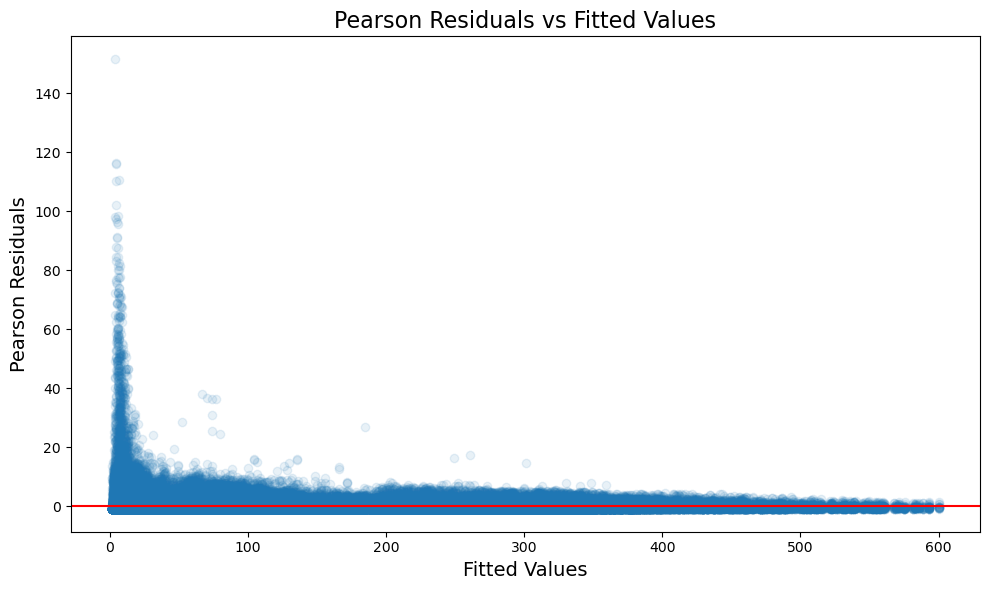

In [6]:
# ---------------------------------------
# RESIDUAL ANALYSIS
# ---------------------------------------

residuals = model_nb.resid_pearson

plt.figure(figsize=(10,6))
plt.scatter(model_nb.fittedvalues, residuals, alpha=0.1)
plt.axhline(0, color='red')
plt.title("Pearson Residuals vs Fitted Values", fontsize=16)
plt.xlabel("Fitted Values", fontsize=14)
plt.ylabel("Pearson Residuals", fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
save_current_figure("residuals_vs_fitted_pedestrians.png")

Saved figure to: ../figures/residuals_vs_fitted_pedestrians.png


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

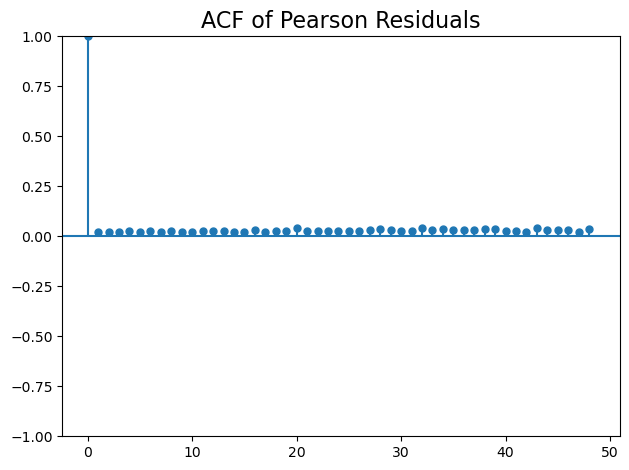

In [7]:
# ---------------------------------------
# AUTOCORRELATION CHECK
# ---------------------------------------

from statsmodels.graphics.tsaplots import plot_acf

# Sort by time first
df_sorted = df.sort_values("datetime")

resid_sorted = residuals[df_sorted.index]

plt.figure(figsize=(10,6))
plot_acf(resid_sorted, lags=48)
plt.title("ACF of Pearson Residuals", fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
save_current_figure("acf_residuals_pedestrians.png")

Saved figure to: ../figures/acf_residuals_pedestrians.png


<Figure size 640x480 with 0 Axes>

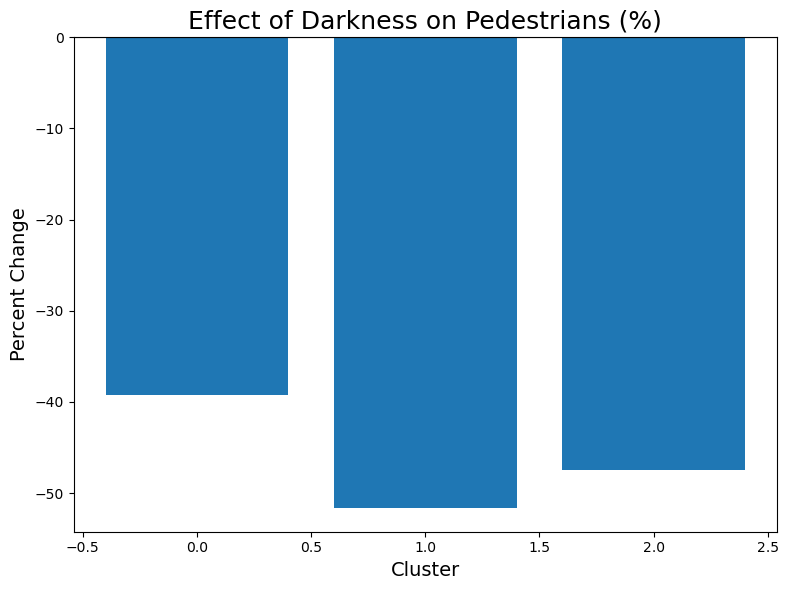

In [8]:
# ---------------------------------------
# VISUALISE DARKNESS EFFECT BY CLUSTER
# ---------------------------------------

effects = []

params = model_nb.params
base_dark = params["Dark"]

for c in sorted(df["cluster_geo"].unique()):
    if c == 0:
        effect = base_dark
    else:
        interaction_term = f"Dark:C(cluster_geo)[T.{c}]"
        effect = base_dark + params.get(interaction_term, 0)
        
    percent_change = (np.exp(effect) - 1) * 100
    effects.append(percent_change)

plt.figure(figsize=(8,6))
plt.bar(sorted(df["cluster_geo"].unique()), effects)
plt.axhline(0, color='black')
plt.title("Effect of Darkness on Pedestrians (%)", fontsize=18)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Percent Change", fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
save_current_figure("darkness_effect_pedestrians.png")

Saved figure to: ../figures/darkness_effect_pedestrians.png


<Figure size 640x480 with 0 Axes>

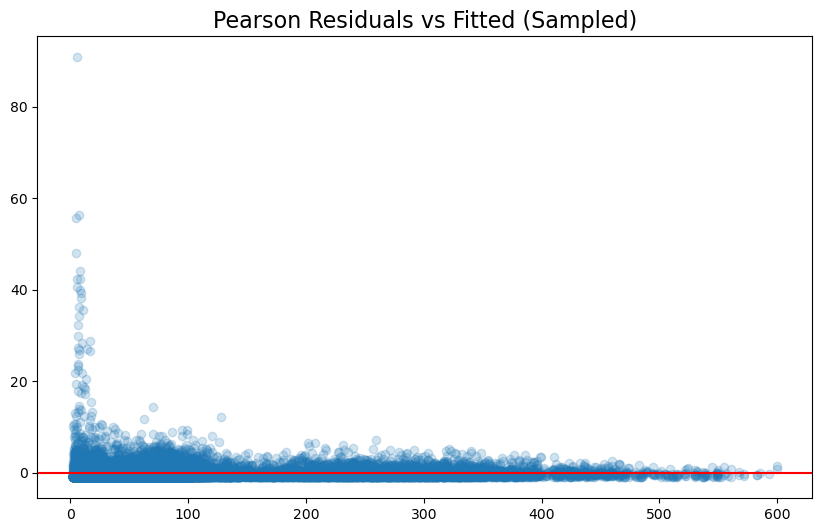

In [9]:
sample_resid = residuals.sample(20000, random_state=1)

plt.figure(figsize=(10,6))
plt.scatter(model_nb.fittedvalues.loc[sample_resid.index], sample_resid, alpha=0.2)
plt.axhline(0, color='red')
plt.title("Pearson Residuals vs Fitted (Sampled)", fontsize=16)
plt.show()

<Figure size 1000x600 with 0 Axes>

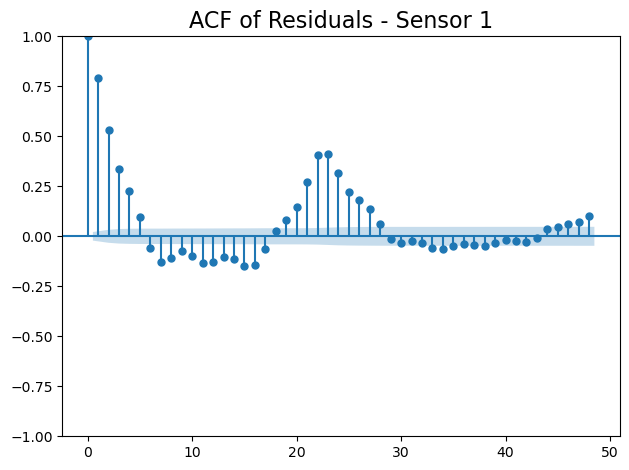

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Pick one sensor
sensor_id_example = df["sensor_id"].iloc[0]

df_sensor = df[df["sensor_id"] == sensor_id_example].sort_values("datetime")

# Get residuals aligned
resid_sensor = model_nb.resid_pearson[df_sensor.index]

plt.figure(figsize=(10,6))
plot_acf(resid_sensor, lags=48)
plt.title(f"ACF of Residuals - Sensor {sensor_id_example}", fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
model_nb_clustered = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.NegativeBinomial()
).fit(cov_type="cluster", cov_kwds={"groups": df["sensor_id"]})

print(model_nb_clustered.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    ped   No. Observations:               378005
Model:                            GLM   Df Residuals:                   377956
Model Family:        NegativeBinomial   Df Model:                           48
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8497e+06
Date:                Thu, 19 Feb 2026   Deviance:                   8.4432e+05
Time:                        22:58:46   Pearson chi2:                 1.60e+06
No. Iterations:                    57   Pseudo R-squ. (CS):             0.7350
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [17]:
os.makedirs("../reports", exist_ok=True)

m = model_nb_clustered  # <-- change if your model variable name differs

# Save full regression table
with open("../reports/pedestrians_nb_clustered_summary.txt", "w") as f:
    f.write(m.summary().as_text())

print("\n" + "="*90)
print("PEDESTRIANS: NEGATIVE BINOMIAL GLM (CLUSTERED SE BY SENSOR)")
print("="*90)
print(f"n obs: {int(m.nobs):,}")
print(f"df_resid: {int(m.df_resid):,}")
print(f"logLik: {m.llf:,.2f}")
print("="*90)
print("Saved full table -> ../reports/pedestrians_nb_clustered_summary.txt")
print("="*90)


PEDESTRIANS: NEGATIVE BINOMIAL GLM (CLUSTERED SE BY SENSOR)
n obs: 378,005
df_resid: 377,956
logLik: -1,849,748.31
Saved full table -> ../reports/pedestrians_nb_clustered_summary.txt


In [18]:
m = model_nb_clustered

params = m.params

def pct_change(beta):
    return (np.exp(beta) - 1.0) * 100.0

clusters = sorted(df["cluster_geo"].dropna().unique())

rows = []
base_dark = params.get("Dark", np.nan)

for c in clusters:
    if c == 0:
        beta = base_dark
    else:
        term = f"Dark:C(cluster_geo)[T.{c}]"
        beta = base_dark + params.get(term, 0.0)
    rows.append({"cluster_geo": c, "beta_dark": beta, "pct_change_dark": pct_change(beta)})

dark_table = pd.DataFrame(rows)
display(dark_table)

# Save small results table
dark_table.to_csv("../reports/pedestrians_darkness_effect_by_cluster_clustered.csv", index=False)
print("Saved -> ../reports/pedestrians_darkness_effect_by_cluster_clustered.csv")

,cluster_geo,beta_dark,pct_change_dark
0,0,-0.497916,-39.220393
1,1,-0.727018,-51.665190
2,2,-0.644429,-47.503777


Saved -> ../reports/pedestrians_darkness_effect_by_cluster_clustered.csv


In [19]:
os.makedirs("../figures", exist_ok=True)

def savefig(name):
    path = f"../figures/{name}"
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print("Saved ->", path)

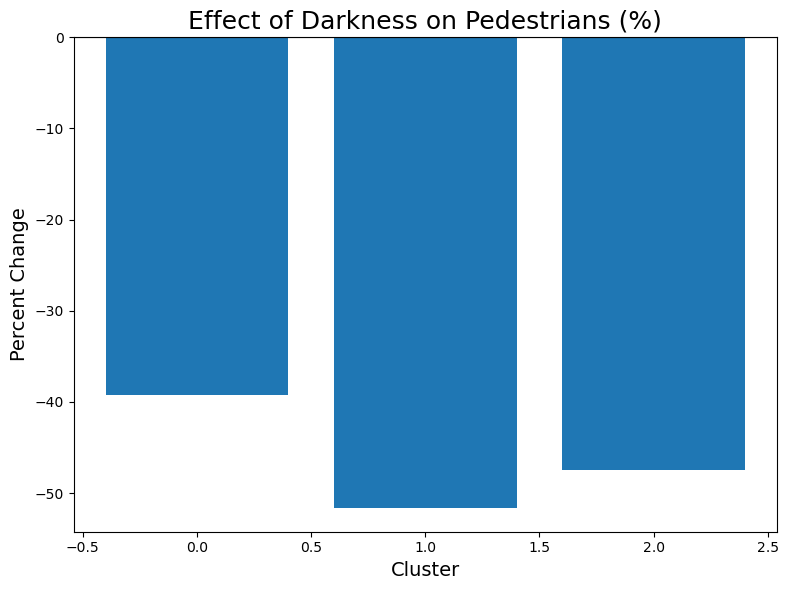

In [20]:
m = model_nb_clustered
params = m.params

def pct_change(beta):
    return (np.exp(beta) - 1) * 100

clusters = sorted(df["cluster_geo"].unique())
effects = []

base_dark = params["Dark"]

for c in clusters:
    if c == 0:
        beta = base_dark
    else:
        beta = base_dark + params.get(f"Dark:C(cluster_geo)[T.{c}]", 0)
    effects.append(pct_change(beta))

plt.figure(figsize=(8,6))
plt.bar(clusters, effects)
plt.axhline(0, color='black')
plt.title("Effect of Darkness on Pedestrians (%)", fontsize=18)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Percent Change", fontsize=14)
plt.tight_layout()

plt.savefig("../figures/ped_darkness_effect_by_cluster_clustered.png", dpi=300)
plt.show()

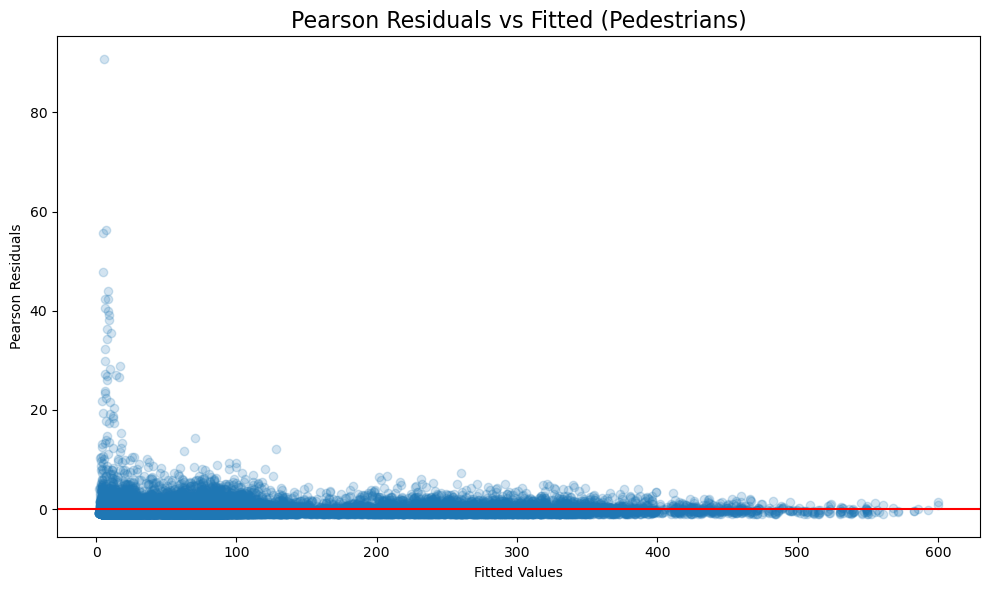

In [21]:
sample_resid = m.resid_pearson.sample(20000, random_state=1)

plt.figure(figsize=(10,6))
plt.scatter(m.fittedvalues.loc[sample_resid.index], sample_resid, alpha=0.2)
plt.axhline(0, color='red')
plt.title("Pearson Residuals vs Fitted (Pedestrians)", fontsize=16)
plt.xlabel("Fitted Values")
plt.ylabel("Pearson Residuals")
plt.tight_layout()

plt.savefig("../figures/ped_residuals_vs_fitted_clustered.png", dpi=300)
plt.show()

<Figure size 1000x600 with 0 Axes>

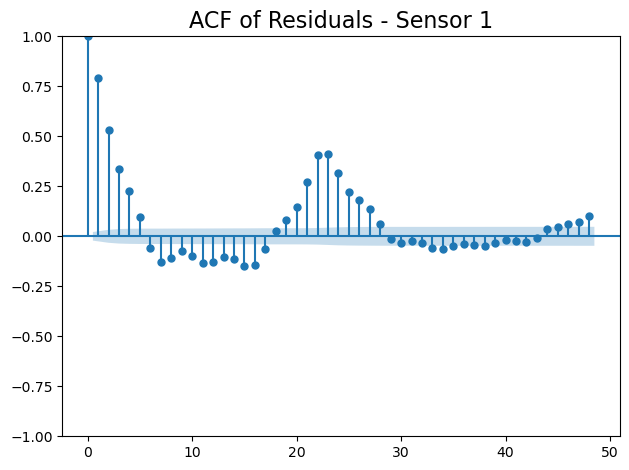

In [22]:

sensor_example = df["sensor_id"].iloc[0]
df_sensor = df[df["sensor_id"] == sensor_example].sort_values("datetime")
resid_sensor = m.resid_pearson[df_sensor.index]

plt.figure(figsize=(10,6))
plot_acf(resid_sensor, lags=48)
plt.title(f"ACF of Residuals - Sensor {sensor_example}", fontsize=16)
plt.tight_layout()

plt.savefig("../figures/ped_acf_sensor_example.png", dpi=300)
plt.show()